## Project: Books Recommender System

Nowadays, in this global world there is a vast number of things to select, where people might be lost. That is the case at the moment of choosing the next book to read. That’s why this project proposal is a book recommender system to help people choose better among a huge set of options.

What you'll find in this notebook is:

- Getting and loading data from this github [Repository](https://github.com/zygmuntz/goodbooks-10k)
- Data Exploration
- Cost function definition
- 2 approaches:
    - Matrix Factorization or Embedding Model
    - Restricted Boltzmann Machines
- Model Execution
- Results

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import random

%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve,auc,roc_auc_score, mean_squared_error


'''Keras and TensorFlow'''
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten
from keras.layers import dot
from keras.layers import BatchNormalization, Input, Lambda
from keras import regularizers
from keras.losses import mse,binary_crossentropy



Using TensorFlow backend.


### Loading Data

The dataset is composed by 3 .csv files provided by this guthub [repository](https://github.com/zygmuntz/goodbooks-10k)

- books.csv: contains metadata for each book. It includes book id, title, author, number of editions, publication year, language, average rating and others

- ratings.csv contains the most important variables for this project, user id, book id and book ratings

- To_read.csv, is the file that provides user IDs and the book IDs that the user has already read

In [2]:
# Loading data for book,csv file

books = pd.read_csv('books.csv')
ratings = pd.read_csv('ratings.csv')
toread = pd.read_csv('to_read.csv')

### Data Exploration

**books.csv**

In [3]:
books.head(8)

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...
5,6,11870085,11870085,16827462,226,525478817,9.780525e+12,John Green,2012.0,The Fault in Our Stars,...,2346404,2478609,140739,47994,92723,327550,698471,1311871,https://images.gr-assets.com/books/1360206420m...,https://images.gr-assets.com/books/1360206420s...
6,7,5907,5907,1540236,969,618260307,9.780618e+12,J.R.R. Tolkien,1937.0,The Hobbit or There and Back Again,...,2071616,2196809,37653,46023,76784,288649,665635,1119718,https://images.gr-assets.com/books/1372847500m...,https://images.gr-assets.com/books/1372847500s...
7,8,5107,5107,3036731,360,316769177,9.780317e+12,J.D. Salinger,1951.0,The Catcher in the Rye,...,2044241,2120637,44920,109383,185520,455042,661516,709176,https://images.gr-assets.com/books/1398034300m...,https://images.gr-assets.com/books/1398034300s...


In [4]:
# Columns and data types

books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
book_id                      10000 non-null int64
goodreads_book_id            10000 non-null int64
best_book_id                 10000 non-null int64
work_id                      10000 non-null int64
books_count                  10000 non-null int64
isbn                         9300 non-null object
isbn13                       9415 non-null float64
authors                      10000 non-null object
original_publication_year    9979 non-null float64
original_title               9415 non-null object
title                        10000 non-null object
language_code                8916 non-null object
average_rating               10000 non-null float64
ratings_count                10000 non-null int64
work_ratings_count           10000 non-null int64
work_text_reviews_count      10000 non-null int64
ratings_1                    10000 non-null int64
ratings_2                    10000 n

In [5]:
# How many unique books and instances there are into this file

# Number of rows
print('Number of rows: {} '.format( books.book_id.count()))

# Unique books
print('Number of unique books: {} '.format(books.book_id.nunique()))

# Number of instances on books file
print('Number of instances: {}'. format(books.book_id.count()*len(books.columns)))

Number of rows: 10000 
Number of unique books: 10000 
Number of instances: 230000


**To read file**

In [6]:
toread.head(8)

,user_id,book_id
0,9,8
1,15,398
2,15,275
3,37,7173
4,34,380
5,34,483
6,34,8598
7,34,3581


In [7]:
toread.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912705 entries, 0 to 912704
Data columns (total 2 columns):
user_id    912705 non-null int64
book_id    912705 non-null int64
dtypes: int64(2)
memory usage: 13.9 MB


In [8]:
# Printing number of rows, instances and unique books and unique users

tr_users = toread.user_id.nunique()
tr_books = toread.book_id.nunique()

print('Number of rows: {}'.format(toread.user_id.count()))
print('Number of instances: {}'.format(toread.user_id.count() * len(toread.columns)))
print('Number of unique users: {} '.format(tr_users))
print('Number of unique books: {} '.format(tr_books))

Number of rows: 912705
Number of instances: 1825410
Number of unique users: 48871 
Number of unique books: 9986 


**ratings.csv**

In [9]:
ratings.head(8)

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3
5,2,26,4
6,2,315,3
7,2,33,4


In [10]:
# Getting info from dataset ratings (columns and data types)

ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5976479 entries, 0 to 5976478
Data columns (total 3 columns):
user_id    int64
book_id    int64
rating     int64
dtypes: int64(3)
memory usage: 136.8 MB


In [11]:
#Let's verify number of instances and number of unique books and users have rated books there are into this file

n_users = ratings.user_id.nunique()
n_books = ratings.book_id.nunique()

print('Number of rows: {}'.format(ratings.user_id.count()))
print('Number of instances: {}'.format(ratings.book_id.count() * len(ratings.columns)))
print('Number of unique users: {} '.format(n_users))
print('Number of unique books: {} '.format(n_books))

Number of rows: 5976479
Number of instances: 17929437
Number of unique users: 53424 
Number of unique books: 10000 


**Ratings file is the most important file for this project. The recommender system is based on items ratings, let's see it in details. 1 is the lowest rate and 5 is the highest rate given a book**

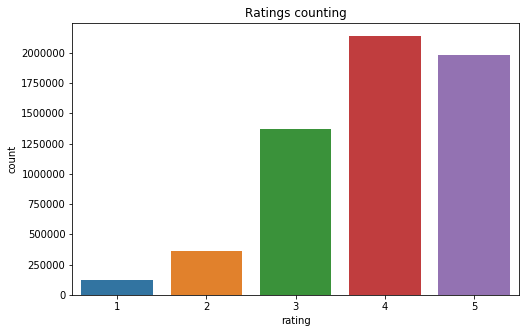

In [12]:
# Plotting the ratings counting

plt.figure(figsize=(8,5))
sns.countplot(x="rating", data=ratings)
plt.title('Ratings counting')
plt.show()

**Let's visualize the average rating per user**

In [13]:
ratings.rating.describe()

count    5.976479e+06
mean     3.919866e+00
std      9.910868e-01
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

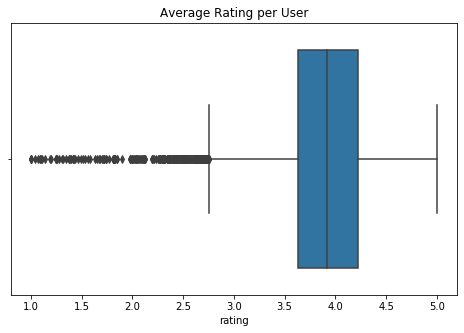

In [14]:
plt.figure(figsize=(8,5))
rating_avg_per_user = ratings[['user_id','rating']].groupby('user_id').mean().sort_values(by=['rating'], ascending=False)
sns.boxplot(x='rating', data=rating_avg_per_user)
plt.title('Average Rating per User')
plt.show()

In [15]:
#ratings[['user_id','book_id']].groupby('user_id').count().sort_values(by=['user_id'], ascending=False)

### Data Cleaning

Null values in dataset should be seen in yellow


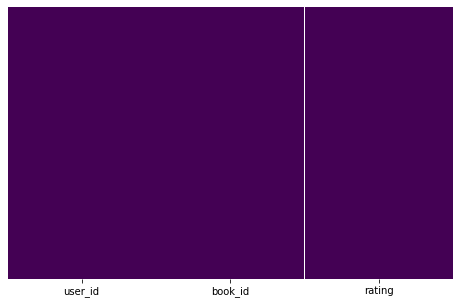

In [16]:
plt.figure(figsize=(8,5))
print('Null values in dataset should be seen in yellow')
sns.heatmap(ratings.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.show()

_As we can see in the graphic above, cleaning is not needed since there are not null values_

### Data Size Reducing

In [17]:
print('Number of unique users: {} '.format(n_users))
print('Number of unique books: {} '.format(n_books))

Number of unique users: 53424 
Number of unique books: 10000 


#### Based on numbers above, let's reduce the complexity and size of this dataset and take the top two thousand most rated books. It represents the 10% of books the dataset contains

In [18]:
#To reduce complexity and size of this dataset

#variable with number of books and users there will be in the new dataset
records = 1000

bookIndex = ratings.groupby('book_id').count().sort_values(by='rating',ascending=False)[0:records].index
ratings_2 = ratings[ratings.book_id.isin(bookIndex)]
ratings_2.count()

user_id    3179650
book_id    3179650
rating     3179650
dtype: int64

#### Let's take just 1000 of users, to reduce the number of ratings from 4034342 to 1000



In [19]:
# Taking 1000 users
userIndex = ratings_2.groupby('user_id').count().sort_values(by='rating',ascending=False).sample(n=records,random_state=2020).index

# Creating the new dataset for working in this project
reducedRatings = ratings_2[ratings_2.user_id.isin(userIndex)]


**Let's reindex book_id and user_id to a range from 1 to 1000**

In [20]:
#Reindexing book_id and user_id to a range from 1 to 1000

bookIDs = reducedRatings.book_id.unique()
bookDF = pd.DataFrame(data=bookIDs,columns=['originalBookId'])
bookDF['newBookId'] = bookDF.index+1


userIDs = reducedRatings.user_id.unique()
userDF = pd.DataFrame(data=userIDs, columns=['originalUserId'])
userDF['newUserId'] = userDF.index+1

reducedRatings = reducedRatings.merge(bookDF, left_on='book_id', right_on='originalBookId')
reducedRatings.drop(labels='originalBookId', axis=1, inplace=True)

reducedRatings = reducedRatings.merge(userDF, left_on='user_id',right_on='originalUserId')
reducedRatings.drop(labels='originalUserId', axis=1, inplace=True)


#### Exploring the reduced dataset

In [21]:
reducedRatings.head()

,user_id,book_id,rating,newBookId,newUserId
0,73,758,5,1,1
1,73,268,4,2,1
2,73,820,5,3,1
3,73,380,5,4,1
4,73,851,4,5,1


In [22]:
n_users = reducedRatings.user_id.nunique()
n_books = reducedRatings.book_id.nunique()
n_ratings = len(reducedRatings)

print('Number of unique users: {} '.format(n_users))
print('Number of unique books: {} '.format(n_books))
print('Number of ratings: {} '.format(n_ratings))


Number of unique users: 1000 
Number of unique books: 1000 
Number of ratings: 58851 


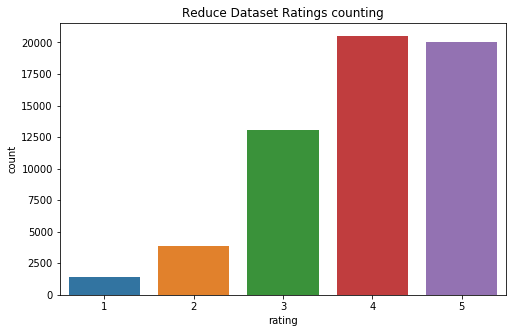

In [23]:
# Plotting the ratings counting

plt.figure(figsize=(8,5))
sns.countplot(x="rating", data=reducedRatings)
plt.title('Reduce Dataset Ratings counting')
plt.show()

_Distribution in the graphic above is very similar to the original dataset_

**Let's generate a test set and validation set**

In [24]:
# Generating train, test and validation sets

X_train, X_test = train_test_split(reducedRatings, test_size = 0.10, shuffle=True, random_state=2020)

X_validation, X_test1 = train_test_split(reducedRatings, test_size = 0.50, shuffle=True, random_state=2020)


print('Train set size: {} '.format(len(X_train)))
print('Validation set size: {} '.format(len(X_validation)))
print('Test set size: {} '.format(len(X_test1)))

Train set size: 52965 
Validation set size: 29425 
Test set size: 29426 


## Cost Function Definition

I will use **Mean Squared Error (MSE)** as cost function to judge the goodness of the models. It measures the averaged square error between the predicted and actual values

<img src='mse.png' size=20%/ width="50%" height="50%">

In [25]:
# Creating a rating matrix for train u x b, 
# where u are the users and the b are the books

ratings_train = np.zeros((n_users,n_books))
for row in X_train.itertuples():    
    ratings_train[row[5]-1, row[4]-1] = row[3]


#Calculating sparcity of train matrix
sparcity = float(len(ratings_train.nonzero()[0]))
sparcity /= (ratings_train.shape[0] * ratings_train.shape[1])
sparcity *= 100
print('Sparcity: {}'.format(round(sparcity,2)))

Sparcity: 5.3


In [26]:
# Creating a rating matrix for validation u x b, 
# where u are the users and the b are the books

ratings_validation = np.zeros((n_users,n_books))
for row in X_validation.itertuples():    
    ratings_validation[row[5]-1, row[4]-1] = row[3]


# Creating a rating matrix for test u x b, 
# where u are the users and the b are the books

ratings_test = np.zeros((n_users,n_books))
for row in X_test.itertuples():    
    ratings_test[row[5]-1, row[4]-1] = row[3]


In [27]:
# Predicting an average rating of 3.5 for the validation set and calculating MSE

actual_validation = ratings_validation[ratings_validation.nonzero()].flatten()

pred_validation = np.zeros((len(X_validation),1))
pred_validation[pred_validation==0] = 3.5
pred_validation

mse = mean_squared_error(pred_validation,actual_validation)

print('Mean squared error using naive prediction: {}'.format(mse))

Mean squared error using naive prediction: 1.2081648258283773


In [28]:
# Predicting based on user's average of all books

ratings_validation_prediction = np.zeros((n_users,n_books))
i = 0
for row in ratings_train:
    ratings_validation_prediction[i][ratings_validation_prediction[i]==0] = np.mean(row[row>0])
    i += 1
    
pred_validation = ratings_validation_prediction[ratings_validation.nonzero()].flatten()
user_average = mean_squared_error(pred_validation,actual_validation)

print('Mean squared error using user average: {}'.format(user_average))

Mean squared error using user average: 0.8434119929918782


In [29]:
# Predicting a users'rating for a given book based on the average rating all books

ratings_validation_prediction = np.zeros((n_users, n_books)).T
i = 0
for row in ratings_train.T:
    ratings_validation_prediction[i][ratings_validation_prediction[i]==0] = np.mean(row[row>0])
    i += 1
    
ratings_validation_prediction = ratings_validation_prediction.T
pred_validation = ratings_validation_prediction[ratings_validation.nonzero()].flatten()

book_average = mean_squared_error(pred_validation,actual_validation)
print('Mean squared error using book average: {}'.format(book_average))

Mean squared error using book average: 0.9427778575574443


## Approach 1: Latent Factor Based or Matrix Factorization



**Matrix factorization** is one of the most popular and succesful collaborative filtering algorithms today. It decomposes the user-item (in this case user-books) into a product of two lower dimensionality matrices.

In [31]:
# Defining this function to avoid repeat code and see results for different latent factors

def perform_MF(latent_factors):

    ''' 
    Function: Create an embedding model using Keras to perform the matrix factorization. It
               receives a number of latent factors    
    '''
    
    n_latent_factors = latent_factors

    #User dimensional vector    
    user_input = Input(shape=[1],name='user')
    user_embedding = Embedding(input_dim=n_users + 1, output_dim=n_latent_factors,
                              name='user_embedding')(user_input)
    user_vector = Flatten(name='flatten_users')(user_embedding)

    #Book dimensional vector
    book_input = Input(shape=[1],name='books')
    book_embedding = Embedding(input_dim=n_books + 1, output_dim=n_latent_factors,
                              name='book_embedding')(book_input)
    book_vector = Flatten(name='flatten_books')(book_embedding)
    
    
    # Generating the output vector to take the dot product of book vector and user vector

    product = dot([user_vector,book_vector], axes=1)
    model = Model(inputs=[user_input,book_input], outputs=product)
    model.compile('adam','mean_squared_error')
    
    # Training model with book and user vectors from the training dataset

    history = model.fit(x=[X_train.newUserId, X_train.newBookId],
                   y=X_train.rating, epochs=50,
                   validation_data=([X_validation.newUserId, 
                   X_validation.newBookId], X_validation.rating),
                   verbose=0)    
    


    return history

### One Latent Factor

In [32]:
# Calling perform_MF function to perform a matrix factorization with 1 latent factor
history = perform_MF(1)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Minimum MSE:  0.7554898454987


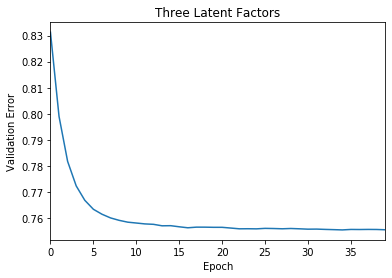

In [33]:
pd.Series(history.history['val_loss'][10:]).plot(logy=False)
plt.xlabel('Epoch')
plt.ylabel('Validation Error')
plt.title('Three Latent Factors')

print('Minimum MSE: ',min(history.history['val_loss']))

### Three Latent Factor

In [34]:
# Calling perform_MF function to perform a matrix factorization with 1 latent factor

history = perform_MF(3)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Minimum MSE:  0.6948812167828835


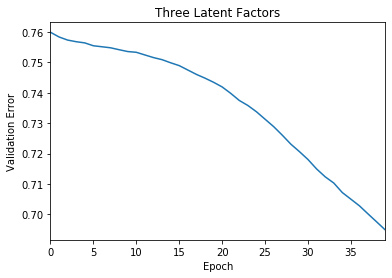

In [35]:
# PLotting results

pd.Series(history.history['val_loss'][10:]).plot(logy=False)
plt.xlabel('Epoch')
plt.ylabel('Validation Error')
plt.title('Three Latent Factors')

print('Minimum MSE: ',min(history.history['val_loss']))

### Five Latent Factors

In [36]:
# Calling perform_MF function to perform a matrix factorization with 1 latent factor

history = perform_MF(5)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Minimum MSE:  0.6083783697150172


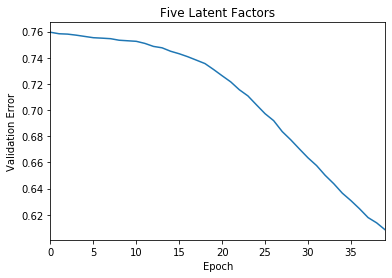

In [37]:
# PLotting results

pd.Series(history.history['val_loss'][10:]).plot(logy=False)
plt.xlabel('Epoch')
plt.ylabel('Validation Error')
plt.title('Five Latent Factors')

print('Minimum MSE: ',min(history.history['val_loss']))

### Ten Factors Latent


In [38]:
# Calling perform_MF function to perform a matrix factorization with 1 latent factor

history = perform_MF(10)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Minimum MSE:  0.4090529900693043


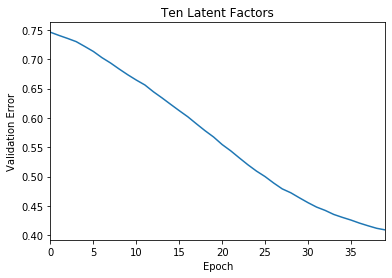

In [39]:
# PLotting results

pd.Series(history.history['val_loss'][10:]).plot(logy=False)
plt.xlabel('Epoch')
plt.ylabel('Validation Error')
plt.title('Ten Latent Factors')

print('Minimum MSE: ',min(history.history['val_loss']))

## Creating Matrix Factorization or Embedding Model (using Keras)

In [41]:
# Creating the model with ten factor latent

n_latent_factors = 10

# User vector
user_input = Input(shape=[1],name='user')
user_embedding = Embedding(input_dim=n_users + 1, output_dim=n_latent_factors, 
                           name='user_embedding')(user_input)
user_vector = Flatten(name='flatten_users')(user_embedding)


# Book vector
book_input = Input(shape=[1],name='books')
book_embedding = Embedding(input_dim=n_books + 1, output_dim=n_latent_factors,
                          name='book_embedding')(book_input)
book_vector = Flatten(name='flatten_books')(book_embedding)


# Generating the output vector to take the dot product of book vector and user vector
product = dot([user_vector,book_vector], axes=1)

# Creating the model
model = Model(inputs=[user_input,book_input], outputs=product)
model.compile('adam','mean_squared_error', metrics=['accuracy'])

# Training the model
history = model.fit(x=[X_train.newUserId, X_train.newBookId],
               y=X_train.rating, 
               epochs=100,
               validation_data=([X_validation.newUserId, X_validation.newBookId], 
               X_validation.rating),
               verbose=0)    

model.summary()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
books (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 10)        10010       user[0][0]                       
__________________________________________________________________________________________________
book_embedding (Embedding)      (None, 1, 10)        10010       books[0][0]                      
____________________________________________________________________________________________

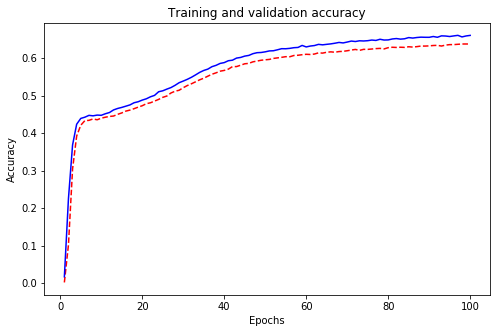

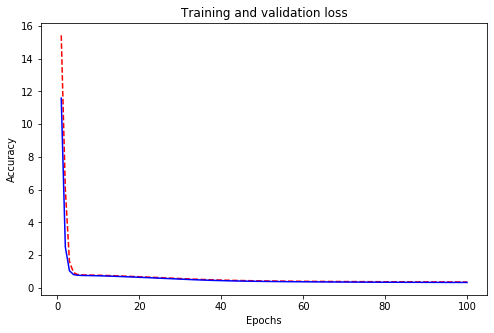

In [42]:
#Plotting training vs validation accuracy and loss

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8,5))
epochs   = range(1,len(acc)+1,1)

plt.plot(epochs,acc, 'r--', label='Training acc'  )
plt.plot(epochs, val_acc,  'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()


plt.figure(figsize=(8,5))
plt.plot(epochs,loss,'r--')
plt.plot(epochs, val_loss,'b')
plt.title('Training and validation loss')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

Minimum MSE:  0.33


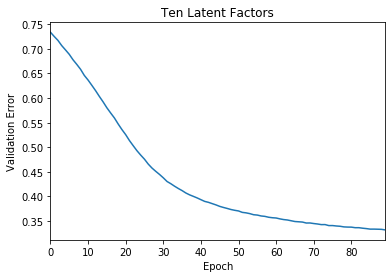

In [43]:
# PLotting results

pd.Series(history.history['val_loss'][10:]).plot(logy=False)
plt.xlabel('Epoch')
plt.ylabel('Validation Error')
plt.title('Ten Latent Factors')

print('Minimum MSE: ',round(min(history.history['val_loss']),2))
mse_embedding = min(history.history['val_loss'])



In [44]:
# Creating a DataFrame for saving results from models
results = pd.DataFrame(columns = ['Model' , 'MSE'])

# Adding result to results dataframe
results = results.append({'Model': 'Matrix Factorization', 
                          'MSE': mse_embedding},
                         ignore_index=True)


### Executing the model and create recommendations for a mock user 

In [46]:
# Creating a dataset for making recommendations from user from 1 to 2000

user_number = 200

book_data = np.array(list(set(reducedRatings.newBookId)))
user_data = np.array([user_number for i in range(len(book_data))])

predictions = model.predict([user_data, book_data])
predictions = np.array([a[0] for a in predictions])
recommended_newbookids = (-predictions).argsort()[:5]
recommendedBookIds = reducedRatings[reducedRatings['newBookId'].isin(recommended_newbookids)]['book_id'].unique()


print('Recommended books for user: {}'.format(user_number))
print(books[books['book_id'].isin(recommendedBookIds)][['original_title','authors']])

Recommended books for user: 200
             original_title                                            authors
347           We Were Liars                                        E. Lockhart
350        Clockwork Prince                                    Cassandra Clare
380      Where the Heart Is                                       Billie Letts
464            In Her Shoes                                    Jennifer Weiner
838  The Merchant of Venice  William Shakespeare, Robert          Jackson, ...


## Approach 2: Restricted Boltzmann Machines

**Restricted Boltzmann Machines (RBM)** consists of a neural network with an input layer (also referred to as the visible layer) and a single hidden layer. The connections among neurons in the same layer are restricted. Neurons in the visible layer communicate with the hidden layer, and then the hidden layer passes back information to the visible layer, going back and forth several times.

The code below is the definition of the RBM class and its functions.

In [48]:
import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


# Defining RBM Class

class RBM(object):
    
    def __init__(self, input_size, output_size, learning_rate,epochs, batchsize):
    
        '''
        Receives input size (number of books) of the RBM, output size, learning rate, 
        number of iterations and the batch size 

        '''
    
        #Defining hyperparameters        
        self._input_size = input_size
        self._output_size = output_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batchsize = batchsize
        
        #Initializing weights and biases using zero matrices
        self.w = np.zeros([input_size,output_size],'float')
        self.hb = np.zeros([output_size], 'float')
        self.vb = np.zeros([input_size], 'float')   
    
        
    # Forward pass
    # hb is a bias vector added at the hidden layer to ensure 
    # at least some of the neurons fire
    
    def prob_h_given_v(self, visible, w, hb):
        return tf.nn.sigmoid(tf.matmul(visible, w) + hb)


    # Backward pass
    # vb is a bias vector added at the visible layer to ensure 
    # at least some of the neurons fire
    
    def prob_v_given_h(self, hidden, w, vb):
        vb = tf.cast(vb, tf.float32)
        return tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(w)) + vb)

    
    # Sampling Function (Gibss Sampling)
    def sample_prob(self, probs):
        return tf.nn.relu(tf.sign(probs - tf.random_uniform(tf.shape(probs))))
    
    
    # Output Function
    def rbm_output(self, X):
        
        input_X = tf.constant(X)
        _w = tf.constant(self.w)
        _hb = tf.constant(self.hb)
        _vb = tf.constant(self.vb)
        out = tf.nn.sigmoid(tf.matmul(input_X, _w) + _hb)
        hiddenGen = self.sample_prob(self.prob_h_given_v(input_X, _w, _hb))        
        visibleGen = self.sample_prob(self.prob_v_given_h(hiddenGen, _w, _vb))
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            return sess.run(out),sess.run(visibleGen),sess.run(hiddenGen)
        


    # Train function    
    def train(self, X, user=1):
    
        # Creating placeholders for weight matrix, hidden bias vector and visible bias vector
        _w = tf.placeholder('float', [self._input_size, self._output_size])
        _hb = tf.placeholder('float',[self._output_size])
        _vb = tf.placeholder('float',[self._input_size])

        # Initializing values in zeros for variables above, to hold previous values
        prv_w = np.zeros([self._input_size,self._output_size], 'float')
        prv_hb = np.zeros([self._output_size],'float')
        prv_vb = np.zeros([self._input_size],float)

        # Initializing values in zeros for variables above, to hold current values
        cur_w = np.zeros([self._input_size,self._output_size], 'float')
        cur_hb = np.zeros([self._output_size],'float')
        cur_vb = np.zeros([self._input_size],float)

        # Creating placeholder for visible layer
        v0 = tf.placeholder('float',[None, self._input_size])
        h0 = self.sample_prob(self.prob_h_given_v(v0, _w, _hb))

        # Setting the output forward pass (v1) and adding the visible bias vector
        v1 = self.sample_prob(self.prob_v_given_h(h0, _w, _vb))
        h1 = self.prob_h_given_v(v1, _w, _hb)

        # Defining the error as MSE
        positive_grad = tf.matmul(tf.transpose(v0), h0)
        negative_grad = tf.matmul(tf.transpose(v1), h1)


        # Create methods to update the weights and biases
        update_w = _w + self.learning_rate * (positive_grad - negative_grad)/tf.to_float(tf.shape(v0)[0])
        update_vb = _vb + self.learning_rate * tf.reduce_mean(v0 - v1,0)
        update_hb = _hb + self.learning_rate * tf.reduce_mean(h0 - h1,0)
        
        
        err = tf.reduce_mean(tf.square(v0 - v1))        
        error_list = []
        
        
        # Initializing the TensorFlow Session with defined variables 
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            for epoch in range(self.epochs):

                for start, end in zip(range(0, len(X),
                    self.batchsize),range(self.batchsize,len(X), self.batchsize)):

                    batch = X[start:end]
                    
                    cur_w = sess.run(update_w, feed_dict={
                        v0 : batch,
                        _w : prv_w,
                        _hb : prv_hb,
                        _vb : prv_vb})
                    
                    cur_hb = sess.run(update_hb, feed_dict={
                        v0 : batch,
                        _w : prv_w,
                        _hb : prv_hb,
                        _vb : prv_vb})
                    
                    cur_vb = sess.run(update_vb, feed_dict={
                        v0 : batch,
                        _w : prv_w,
                        _hb : prv_hb,
                        _vb : prv_vb})
                    
                    prv_w = cur_w
                    prv_hb = cur_hb
                    prv_vb = cur_vb
                    
                    error = sess.run(err, feed_dict={v0:X, _w:cur_w, _vb:cur_vb, _hb: cur_hb})
                    error_list.append(error)
                    
                    print('Epoch: {} ,reconstruction error: {} '.format(epoch, error))

           
            
            # Feeding the User
            
            inputUser = [X[user]]
            hh0 = tf.nn.sigmoid(tf.matmul(v0,_w) + _hb)
            vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(_w)) + _vb)
            feed = sess.run(hh0, feed_dict={v0: inputUser, _w: prv_w, _hb: prv_hb})
            rec = sess.run(vv1, feed_dict={hh0: feed, _w: prv_w, _vb: prv_vb})

            self.w = prv_w
            self.hb = prv_hb
            self_vb = prv_vb  
            
            return error_list,rec


    # Obtaining recommendation for an user    
    def calculate_scores(self, ratings, books, to_read, rec, user):
        
        
        # Creating recommendation score for books in our data
        num_rows = records
        temp = ratings.sort_values(by=['user_id'], ascending=True)
        ratings = temp.iloc[:num_rows, :]
        ratings['Recommendation_Score'] = rec[0]

        
        # Finding mock user's user_id from the data
        cur_user_id = ratings.iloc[user]['user_id']

        # Finding books the user has read before
        read_books = ratings[ratings['user_id'] == cur_user_id]['book_id']
        read_books

        # Converting the pandas object into a list
        read_books_id = read_books.tolist()

        # Getting book names and authors for the books already read by the user
        read_books_names = []
        read_books_authors = []
        for book in read_books_id:
            read_books_names.append(
                books[books['book_id'] == book]['original_title'].tolist()[0])
            read_books_authors.append(
                books[books['book_id'] == book]['authors'].tolist()[0])

        # Finding all books the mock user has 'not' read before using the to_read data
        unread_books = to_read[to_read['user_id'] == cur_user_id]['book_id']
        unread_books_id = unread_books.tolist()

        # Extracting  ratings of all the unread books from ratings dataframe
        unread_with_score = ratings[ratings['book_id'].isin(unread_books_id)]

        # Grouping the unread data on book id and taking the mean of the recommendation scores for each book_id
        grouped_unread = unread_with_score.groupby('book_id', as_index=False)[
            'Recommendation_Score'].mean()

        # Getting the names and authors of the unread books
        unread_books_names = []
        unread_books_authors = []
        unread_books_scores = []
        for book in grouped_unread['book_id']:
            unread_books_names.append(
                books[books['book_id'] == book]['original_title'].tolist()[0])
            unread_books_authors.append(
                books[books['book_id'] == book]['authors'].tolist()[0])
            unread_books_scores.append(
                grouped_unread[grouped_unread['book_id'] == book]['Recommendation_Score'].tolist()[0])

        # Creating a data frame for unread books with their names, authors and recommendation scores
        unread_books_with_scores = pd.DataFrame({
            'book_name': unread_books_names,
            'book_authors': unread_books_authors,
            'score': unread_books_scores
        })

        # Creating a data frame for read books with the names and authors
        read_books_with_names = pd.DataFrame({
            'book_name': read_books_names,
            'book_authors': read_books_authors
        })

        return unread_books_with_scores, read_books_with_names

In [58]:
# Training the model

inputX = ratings_train
inputX = inputX.astype(np.float32)

#Parameters: input_size, output_size, learning_rate, epochs, batchsize
#records variable was set above at the moment dataset were reduced to 2000 unique books and 2000 unique users

rbm = RBM(records,records,0.3,230,200)

In [59]:
# Train RBM model
err,rec = rbm.train(inputX,1)
outputX, reconstructedX, hiddenX = rbm.rbm_output(inputX)

Epoch: 0 ,reconstruction error: 0.890736997127533 
Epoch: 0 ,reconstruction error: 0.9622439742088318 
Epoch: 0 ,reconstruction error: 0.9571250081062317 
Epoch: 0 ,reconstruction error: 0.9165940284729004 
Epoch: 1 ,reconstruction error: 0.8986480236053467 
Epoch: 1 ,reconstruction error: 0.8948749899864197 
Epoch: 1 ,reconstruction error: 0.8898599743843079 
Epoch: 1 ,reconstruction error: 0.881072998046875 
Epoch: 2 ,reconstruction error: 0.8851730227470398 
Epoch: 2 ,reconstruction error: 0.8750560283660889 
Epoch: 2 ,reconstruction error: 0.8649100065231323 
Epoch: 2 ,reconstruction error: 0.8630250096321106 
Epoch: 3 ,reconstruction error: 0.8678629994392395 
Epoch: 3 ,reconstruction error: 0.8639730215072632 
Epoch: 3 ,reconstruction error: 0.8547559976577759 
Epoch: 3 ,reconstruction error: 0.855430006980896 
Epoch: 4 ,reconstruction error: 0.8603100180625916 
Epoch: 4 ,reconstruction error: 0.8607180118560791 
Epoch: 4 ,reconstruction error: 0.8550509810447693 
Epoch: 4 ,recon

Epoch: 39 ,reconstruction error: 0.8092349767684937 
Epoch: 39 ,reconstruction error: 0.7996399998664856 
Epoch: 39 ,reconstruction error: 0.8064209818840027 
Epoch: 40 ,reconstruction error: 0.8095600008964539 
Epoch: 40 ,reconstruction error: 0.8057039976119995 
Epoch: 40 ,reconstruction error: 0.7977290153503418 
Epoch: 40 ,reconstruction error: 0.8032820224761963 
Epoch: 41 ,reconstruction error: 0.806676983833313 
Epoch: 41 ,reconstruction error: 0.8052629828453064 
Epoch: 41 ,reconstruction error: 0.7958099842071533 
Epoch: 41 ,reconstruction error: 0.8028659820556641 
Epoch: 42 ,reconstruction error: 0.8062989711761475 
Epoch: 42 ,reconstruction error: 0.8020970225334167 
Epoch: 42 ,reconstruction error: 0.796405017375946 
Epoch: 42 ,reconstruction error: 0.8005719780921936 
Epoch: 43 ,reconstruction error: 0.8055559992790222 
Epoch: 43 ,reconstruction error: 0.800931990146637 
Epoch: 43 ,reconstruction error: 0.7951549887657166 
Epoch: 43 ,reconstruction error: 0.79961699247360

Epoch: 78 ,reconstruction error: 0.7952749729156494 
Epoch: 78 ,reconstruction error: 0.7959949970245361 
Epoch: 78 ,reconstruction error: 0.7877820134162903 
Epoch: 78 ,reconstruction error: 0.787738025188446 
Epoch: 79 ,reconstruction error: 0.7948570251464844 
Epoch: 79 ,reconstruction error: 0.7953799962997437 
Epoch: 79 ,reconstruction error: 0.7875049710273743 
Epoch: 79 ,reconstruction error: 0.7879970073699951 
Epoch: 80 ,reconstruction error: 0.7948560118675232 
Epoch: 80 ,reconstruction error: 0.7954699993133545 
Epoch: 80 ,reconstruction error: 0.7875440120697021 
Epoch: 80 ,reconstruction error: 0.7880839705467224 
Epoch: 81 ,reconstruction error: 0.7937639951705933 
Epoch: 81 ,reconstruction error: 0.7946509718894958 
Epoch: 81 ,reconstruction error: 0.7876290082931519 
Epoch: 81 ,reconstruction error: 0.7875199913978577 
Epoch: 82 ,reconstruction error: 0.7948399782180786 
Epoch: 82 ,reconstruction error: 0.7943140268325806 
Epoch: 82 ,reconstruction error: 0.787593007087

Epoch: 117 ,reconstruction error: 0.7907090187072754 
Epoch: 117 ,reconstruction error: 0.7854200005531311 
Epoch: 117 ,reconstruction error: 0.7845010161399841 
Epoch: 118 ,reconstruction error: 0.7883250117301941 
Epoch: 118 ,reconstruction error: 0.7905139923095703 
Epoch: 118 ,reconstruction error: 0.785444974899292 
Epoch: 118 ,reconstruction error: 0.7847110033035278 
Epoch: 119 ,reconstruction error: 0.7884309887886047 
Epoch: 119 ,reconstruction error: 0.7904260158538818 
Epoch: 119 ,reconstruction error: 0.7856850028038025 
Epoch: 119 ,reconstruction error: 0.7846400141716003 
Epoch: 120 ,reconstruction error: 0.7883449792861938 
Epoch: 120 ,reconstruction error: 0.7903850078582764 
Epoch: 120 ,reconstruction error: 0.7854509949684143 
Epoch: 120 ,reconstruction error: 0.7852150201797485 
Epoch: 121 ,reconstruction error: 0.7882390022277832 
Epoch: 121 ,reconstruction error: 0.7901700139045715 
Epoch: 121 ,reconstruction error: 0.7855470180511475 
Epoch: 121 ,reconstruction er

Epoch: 156 ,reconstruction error: 0.7849060297012329 
Epoch: 156 ,reconstruction error: 0.7839540243148804 
Epoch: 157 ,reconstruction error: 0.7861549854278564 
Epoch: 157 ,reconstruction error: 0.7882829904556274 
Epoch: 157 ,reconstruction error: 0.7847170233726501 
Epoch: 157 ,reconstruction error: 0.78398597240448 
Epoch: 158 ,reconstruction error: 0.7860360145568848 
Epoch: 158 ,reconstruction error: 0.7880070209503174 
Epoch: 158 ,reconstruction error: 0.784604012966156 
Epoch: 158 ,reconstruction error: 0.7839000225067139 
Epoch: 159 ,reconstruction error: 0.7858009934425354 
Epoch: 159 ,reconstruction error: 0.7879649996757507 
Epoch: 159 ,reconstruction error: 0.7844629883766174 
Epoch: 159 ,reconstruction error: 0.7840560078620911 
Epoch: 160 ,reconstruction error: 0.7858740091323853 
Epoch: 160 ,reconstruction error: 0.7883110046386719 
Epoch: 160 ,reconstruction error: 0.7845630049705505 
Epoch: 160 ,reconstruction error: 0.7836329936981201 
Epoch: 161 ,reconstruction erro

Epoch: 195 ,reconstruction error: 0.7847790122032166 
Epoch: 195 ,reconstruction error: 0.7841100096702576 
Epoch: 196 ,reconstruction error: 0.7855920195579529 
Epoch: 196 ,reconstruction error: 0.7876729965209961 
Epoch: 196 ,reconstruction error: 0.7846450209617615 
Epoch: 196 ,reconstruction error: 0.7845640182495117 
Epoch: 197 ,reconstruction error: 0.7860599756240845 
Epoch: 197 ,reconstruction error: 0.7878069877624512 
Epoch: 197 ,reconstruction error: 0.7847840189933777 
Epoch: 197 ,reconstruction error: 0.7843480110168457 
Epoch: 198 ,reconstruction error: 0.7857469916343689 
Epoch: 198 ,reconstruction error: 0.7875930070877075 
Epoch: 198 ,reconstruction error: 0.7848150134086609 
Epoch: 198 ,reconstruction error: 0.7841860055923462 
Epoch: 199 ,reconstruction error: 0.7855910062789917 
Epoch: 199 ,reconstruction error: 0.7875549793243408 
Epoch: 199 ,reconstruction error: 0.784600019454956 
Epoch: 199 ,reconstruction error: 0.7842190265655518 
Epoch: 200 ,reconstruction er

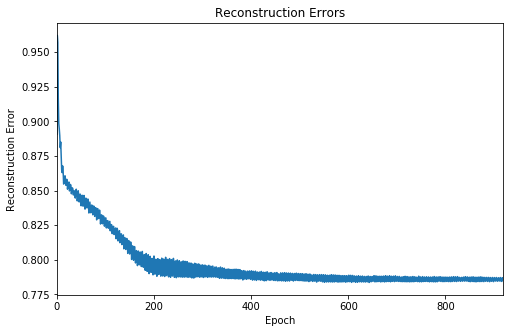

In [60]:
# Plot reconstruction errors

plt.figure(figsize=(8,5))
pd.Series(err).plot(logy=False)
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Errors')
plt.show()

In [61]:
# Predicting ratings for validation set

inputValidation = ratings_validation
inputValidation = inputValidation.astype(np.float32)

finalOutput_validation, reconstructedOutput_validation, _ = rbm.rbm_output(inputValidation)

# Calculating MSE for validation set

predictionsArray = reconstructedOutput_validation
pred_validation = predictionsArray[ratings_validation.nonzero()].flatten()
actual_validation = ratings_validation[ratings_validation.nonzero()].flatten()

rbm_prediction = mean_squared_error(pred_validation, actual_validation)

# Adding results to results dataframe
results = results.append({'Model': 'Restricted Boltzmann Machine', 
                          'MSE': rbm_prediction}, ignore_index=True)

print('Mean squared error using RBM prediction:', round(rbm_prediction,2))

Mean squared error using RBM prediction: 12.15


### Recommendations for a mock user

In [70]:
#mock user id
user=987

# Getting recommended books for mock user
unread, read = rbm.calculate_scores(reducedRatings, books, toread, rec, user)

# Listing recommended books for mock user
unread[['book_name','book_authors']]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,book_name,book_authors
0,The Girl on the Train,Paula Hawkins
1,The Road,Cormac McCarthy
2,ねじまき鳥クロニクル [Nejimakidori kuronikuru],"Haruki Murakami, Jay Rubin"
3,Cloud Atlas,David Mitchell


## Results

In [82]:
results

,Model,MSE
0,Matrix Factorization,0.332057
1,Restricted Boltzmann Machine,12.150620


_________________________________________________________

By: Wendy Navarrete

November 2019